This notebook is intended to anyalize and desplay the data from the cataloges generated

In [2]:
#steal the includes from the other journals
from astropy.io import fits
from astropy.table import Table#helps read sexfiles
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
from astropy import wcs
import scipy as sp
import math
from io import StringIO
from astropy.io import ascii

In [3]:
#import the catalogues
j0205Red="/home/wes/Astronomy/Code/catalog_creation/source_extractor/oldj0205red.fits"
j0205Blue="/home/wes/Astronomy/Code/catalog_creation/source_extractor/oldj0205blue.fits"
hdulist = fits.open(j0205Red)
r=Table.read(hdulist[1])#r = red
hdulist = fits.open(j0205Blue)
b=Table.read(hdulist[1])#b= blue

In [22]:
print(r)

#%%capture cap --no-stderr
#np.savetxt("output.txt",r)
#print(r)


#myFile = open("catOutput.txt","w")
#myFile.write(r.pprint(max_width=-1))
#myFile.close()

NUMBER  X_IMAGE   Y_IMAGE  ALPHA_J2000 ... A_IMAGE B_IMAGE THETA_IMAGE
          pix       pix        deg     ...   pix     pix       deg    
------ --------- --------- ----------- ... ------- ------- -----------
     1 3017.0647 2164.6582  31.4497661 ...   1.296   0.618      -49.77
     2 2957.5374 2182.2493  31.4529322 ...   0.912   0.433       -0.36
     3 3042.2898 2251.3616  31.4484239 ...   1.656   1.446      -72.72
     4 2897.6177 2251.1328  31.4561184 ...   1.184   1.039       18.81
     5 2994.1917 2284.4846  31.4509817 ...   1.909   1.774      -48.83
     6 2919.8904 2293.0117  31.4549333 ...   7.044   2.098      -13.12
   ...       ...       ...         ... ...     ...     ...         ...
  1435 3228.2346 4210.3179  31.4385373 ...   1.261   0.905      -50.34
  1436 3007.1226 4218.6406  31.4502791 ...   1.492   1.306       18.28
  1437 3262.0393 4230.3638  31.4367422 ...   1.566    1.28       61.29
  1438 3316.8909 4226.3926  31.4338294 ...   0.992   0.584       43.78
  1439

TypeError: write() argument must be str, not None

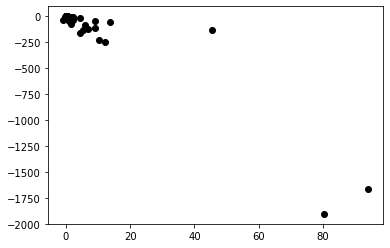

In [6]:
#lets make a b-r to b plot
dF=b['FLUX_AUTO']-r['FLUX_AUTO']#dF = delta Flux
bx=b['FLUX_AUTO']#bx = b axis
#print(dF)
#print(bx)
plt.plot(bx, dF, 'o', color='black');

Okay, I see 3 "outliers" I never fixed those weight problems so maybe thats the cause, for now I am going to manualy remove these 3 untill I get something out of this graph then I am going to fix code.

In [7]:
#code to help me find the max blue flux galaxy.
#first run 1119
bucket=0
bucket1=0
bucket2=0
bucketnum=-1
bucketnum1=-1
bucketnum2=-1
for i in range(0,len(bx)):
    if(bx[i]>bucket):
        bucket2=bucket1
        bucketnum2=bucketnum1
        bucket1=bucket
        bucketnum1=bucketnum
        bucket=bx[i]
        bucketnum=i
toDelete=[bucketnum,bucketnum1,bucketnum2]
print(bucketnum)
print(bx[bucketnum])
print(dF[bucketnum])

print(bucketnum1)
print(bx[bucketnum1])
print(dF[bucketnum1])

print(bucketnum2)
print(bx[bucketnum2])
print(dF[bucketnum2])

1119
93.81167309806504
-1666.6885858928297
15
80.16843835326375
-1905.4800419018795
12
10.334173188312622
-226.79834006206175


1441
1438


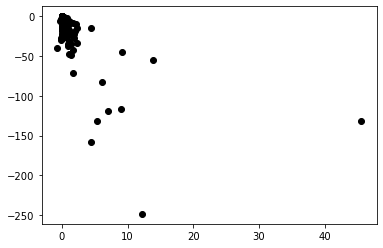

In [8]:
ndF = np.zeros(len(dF))#new dF
nbx = np.zeros(len(bx))
for i in range(0,len(bx)):
    ndF[i] = dF[i]
    nbx[i] = bx[i]
dndF=np.delete(ndF,toDelete)#deleted new dF
dnbx=np.delete(nbx,toDelete)
print(len(ndF))
print(len(dndF))
plt.plot(dnbx, dndF, 'o', color='black');
#for i in range(0,len(dnbx)):
#    dndF[i] = math.log(abs(dndF[i]),10)
#    dnbx[i] = math.log(abs(dnbx[i]),10)
#plt.plot(dnbx, dndF, 'o', color='black');
#there are kind of two lines, star-forming vs quesent, we will probably see once we have more data

(-40.0, 1.0)

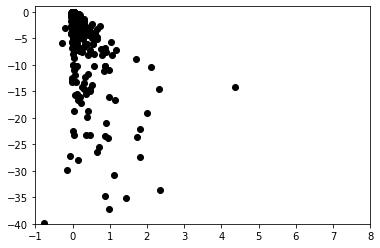

In [9]:
#what was i thinking ealier, just zoom in
plt.plot(dnbx, dndF, 'o', color='black');
ax = plt.gca()
ax.set_xlim([-1, 8])
ax.set_ylim([-40, 1])


In [10]:
#lets convert flux auto to magnitude.
#what exactly are the values here
print (r['FLUX_AUTO'])
print (b['FLUX_AUTO'])

    FLUX_AUTO     
        ct        
------------------
1.1136686700176441
0.5878395036678419
1.9561682559340077
5.9468169440039675
 3.965581397091786
 9.217320840838955
               ...
1.9158391337269702
0.6390559260958532
3.8489269192442523
0.6157946883599399
 4.078597658678593
1.4362482846276883
0.6550035677602433
Length = 1441 rows
      FLUX_AUTO       
          ct          
----------------------
   0.01372946371007975
   0.04916807236840688
  0.025982524396136644
  0.008234379246295458
   0.02126466888940682
    1.0540421362087282
                   ...
  0.016332474989925495
   0.05131817432228073
  0.015807468376817246
-0.0009528688498266258
-0.0034860772629426674
-0.0017177221541253799
0.00015510693606717542
Length = 1441 rows


In [11]:
#m1 = -2.5log(f/3880)
#first lets create the magnitude arrays
mr = np.zeros(len(r['FLUX_AUTO']))#magnitude red
mb = np.zeros(len(b['FLUX_AUTO']))

for i in range(0,len(r['FLUX_AUTO'])):
    mr[i] = -2.5*(math.log((r['FLUX_AUTO'][i]/3880),10))
    if(b['FLUX_AUTO'][i]>=0):
        mb[i] = -2.5*(math.log((b['FLUX_AUTO'][i]/3880),10))
    else:
        mb[i]=mr[i]
        print(mb[i])
        
#find the correct fluxes and use the correct divide by

9.274571876525998
9.498639849110996
6.200812861089986
6.22137988655351
8.799425582673049
5.390863780519474
7.456036535126741
10.02235934329211
8.360999821476133
10.673554233684552
7.841333858074089
11.33844911436385
11.11971826093189
12.458782264588136
9.4656268107302
9.203079171798977
9.075534347268263
10.362764669022596
12.065886905814054
9.786208477317631
11.810991218987798
10.92260933294904
10.68013847035151
8.915297622417583
9.62765226625844
11.116530987772746
11.67502291565204
11.814521887817602
6.871499440331235
11.370832672244386
10.008945754224872
12.048827501889086
11.935255655857343
10.838158438497029
9.131675529622223
7.872132238231942
11.66661638526657
10.341956628033751
11.89220852482225
11.362706819338177
8.992620454863676
10.862769197717464
11.905847523309802
10.959767975569035
12.1018165531512
10.590174860301751
11.92820445110443
11.797330348428591
8.346434118429748
10.01195494993244
10.915047562414749
12.374912062125453
7.087838335226191
7.064815159403342
8.8882695216

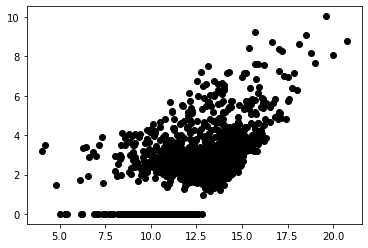

In [12]:
plt.plot(mb, mb-mr, 'o', color='black');